# Implementation notes

Below follows further descriptions, as well as some comments and thoughts upon questions that came up upon the attempt to implement each and one of these algorithms.

1. Double DQN
2. Prioritized experience replay DQN
3. Dueling DQN
4. Multi-step learning
5. c51 / Distributional DQN

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math

import tensorflow as tf

from tensorflow.keras import Model
from tensorflow.keras.layers import Input, Dense, Lambda
from tensorflow.keras import backend as K

/usr/lib/python3/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## 1 - Double DQN

**Description**

They show that Q learning can suffer from over optimistic estimations of the value function. The idea of Double DQN is to decompose the max operation in the target into action selection and action evaluation. The proposition is to evaluate the greedy policy according to the online network, but using the target network to estimate its value. The parameter update of the online network is the same as for DQN, with the target term $Y_{t}^{DQN}$ replaced with:

$$Y_{t}^{DoubleDQN} = R_{t+1} + \gamma Q(S_{t+1}, \underset{a}{\mathrm{argmax}}Q(S_{t+1}, a, \theta),\hat{\theta})$$

Where $\theta$ are the parameters of the online network to be updated online, and where $\hat{\theta}$ are the parameters of the target network and is a mere periodic copy of its online equivalent.

Note that there implementation-wise are no further additions to the DQN setup beyond the target term $Y_{t}^{DoubleDQN}$.

**Type of implementation wrt to DQN**

By an additional estimation of action values, and,
by adjusting the target term.

## 2 - Prioritized experience replay DQN

**Description**

Prioritized replay is a method that can make learning from experience more efficient. The key idea is that an agent can learn more effectively from some transitions than from others. One would prefer to sample more prioritized and relevant transitions than to simply sample them uniformly. This is what prioritized replay allows for.

In the paper they discuss the TD error, or the magnitude of a transitions TD error $\delta$, as a measure on how surprising or unexpected a transition is. However, due to a number of issues they instead introduce a stochastic sampling method that interpolates between pure greedy prioritization and uniform random sampling. Finally, due to a bias that arises in the sampling distribution, they introduce an importance sampling in order to correct that.

Conceptualizing this comes quite natural, but implementing can not be said to be as natural..

**Steps of implementation**

1. Sample an action.
2. Obtain experience tuple from environment.
3. Store transition in a sum tree as per its priority.
4. Sample a batch of transitions from the sum tree as per their priorities
5. Estimate gradients and update parameters, importance sampling weight is included.
6. Update priorities with their new TD errors.

**Type of implementation wrt DQN**

* Implementation of Prioritized Replay includes a multiple of methods from a couple of classes.
* Implementation in article is built upon DQN + Double DQN.

## 3 - Dueling DQN

**Description**

The key insight is that for many states, it is unnecessary to estimate each of the state action values. The dueling contribution is in the form of a network and not as some additional algorithmic steps.

Basically the upper part of the DQN network is divided into two separate streams of fully connected layers. These streams have separate parameters $\alpha, \beta$ and the first one outputs a scalar which is an estimate of the state value function $V(s, \theta, \alpha)$, where $\theta$ are the parameters of the bottom convolutional layers. The second stream outputs a vector with a length of the total number of actions $|A|$, and this represent the advantage function $A(s, a, \theta, \beta)$.

On top of these two stream outputs there is a module (a custom layer?), here the action values are computed based on the state value and the differences between respective advantage value and the mean of all the advantage values.

$$Q(s, a, \theta, \alpha, \beta) = V(s, \theta, \alpha) + (, A(s, a, \theta, \beta)-\frac{1}{|A|}\sum_{a' \epsilon |A|} A(s, a', \theta, \beta) ),$$

The output from all of this is then a vector, a vector of action values $Q(s, a, \theta, \alpha, \beta)$.

The subtracting mean operation does not change the relative rank of the $A$, hence while acting it is only necessary to evaluate the advantage stream.

**Type of implementation**

* Implementation comes in the form of a network architecture.
* Implementation in the article is built upon Double DQN + Double DQN + both of the memory replays.

**Initial thoughts on network architecture**

In [3]:
def subtract_mean(args, action_space, batchsize):
    v = args[0]
    A = args[1]
    A_mean = tf.math.reduce_mean(A)
    A_sub_mean = tf.math.subtract(A, A_mean)
    V = tf.broadcast_to(v, [batchsize, action_space])
    Q = tf.math.add(V, A_sub_mean)
    return Q

def dueling(batchsize=2, input_shape=(2,), action_space=2):
    # Bottom layers
    inputs = Input(shape=input_shape)
    x = Dense(20, activation='relu', name='theta_1')(inputs)
    x = Dense(20, activation='relu', name='theta_2')(x)
    x = Dense(20, activation='relu', name='theta_3')(x)
    # Value stream
    v = Dense(10, activation='relu', name='alpha_1')(x)
    v = Dense(1, activation='linear', name='alpha_out')(v)
    # Advantage stream
    a = Dense(10, activation='relu', name='beta_1')(x)
    a = Dense(action_space, activation='linear', name='beta_out')(a)
    # Network output
    outputs = Lambda(subtract_mean, arguments={
        'action_space': action_space, 'batchsize': batchsize})([v, a])
    Model(inputs, outputs).summary()

dueling()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 2)]          0                                            
__________________________________________________________________________________________________
theta_1 (Dense)                 (None, 20)           60          input_1[0][0]                    
__________________________________________________________________________________________________
theta_2 (Dense)                 (None, 20)           420         theta_1[0][0]                    
__________________________________________________________________________________________________
theta_3 (Dense)                 (None, 20)           420         theta_2[0][0]                    
_____________

## 4 - n-step Q learning

**Description**

Consider the space in between one step TD bootstrapping on the one hand, and the Monte Carlo methods with episodic updates on the other. This is where the n-step bootstrapping methods lie. Benefit is that it might be favorable to bootstrap over more steps than one in order to capture potential state changes, meanwhile not being subjected to the hastiness of the single step.

Basically it goes like this: instead of estimating some value $V(s_t)$ based on a discounted estimation of the value of the next step $\gamma V(s_{t + 1})$ (bootstrapping), consider estimating the value $V(s_t)$ based on an estimated value, or return $G$, from $n$-steps. First of all we want to define that return $G$:

$$G^{(n)}{t:t+n} = R{t+1} + \gamma R_{t+2} + ... + \gamma^{n-1}R_{t+n} + \gamma^n V_{t+n-1}(S_{t+n})$$

This is to be understood as such, that in order to obtain the truncated return of timestep $t$, from $t$ to $t+n$ steps, one sums up the discounted rewards from the $n$-step window and complement that in the end by adding the discounted value from the final step. This final step value represents the expected value from all the future steps as usual. In practical terms, this obviously means that one has to visit all these states in the $n$-step window in order to gain access to the rewards.

Easily transfered into a context of control, an update rule for action values can then be:

$$Q_{t+n}(S_t, A_t) = Q_{t+n-1}(S_t, A_t) + \alpha[G_{t:t+n} + Q_{t+n-1}(S_t, A_t)]$$

**Question marks**

There are quite a few blurs, at least when it comes to implementing it in a DQN context. We can act in the environment and generate transitions as usual and store them in the memory, no problem. But what about the training step? Here are some current thoughts on this:

Say that we have a batch of 1 to start with and that $n = 5$, lets break down what we need in order to make that update. We will need to sample $n$ transitions from the memory in order to populate the $n$-step sequence.

* Question: Can we sample these $n$ samples freely from the replay buffer? Can there be a variance from the full memory? Or do we need to restrict our samples to some segments of more nearby neighbors?

Say that we are successful in obtaining our $n$ samples representing an ordered $n$-step sequence of transitions. From here we can compute the return $G^{(n)}_t$ by simply adding up the discounted rewards in the sequence.

* Question: Is it enough to just add them up. What about the final term in the sequence, the value representing future expected values? I'm leaning towards just adding up the discounted terms and thats that, see Rainbow article equation (2).

When we have the return $G^{(n)}t$, it seems like we want to estimate target values given the state $S{t+n}$ such that the target value is: $\max_{a'}Q(S_{t+n}, a')$. Furthermore, values to put up against the target seem to be $Q(S_t, A_t)$. Hence the $n$-step procedure takes the values from state $S_t$, and the targets from state $S_{t+n}$. Obviously there are separate parameters and all that but this should provide us with what we need.

* Question: What about training time? Well, even though we sample $n$ transitions for each entry in the batch of size batchsize, all we really need to use them for is to iterate over their collected rewards. Then we use the front and the back to estimate values, but thats 2 propagations total just as usual. Then its the training step. So all good at least on this point it seems.

What remains is the procedure with the replay buffer. Lets start with applying n-steps with experience replay, since it is a lot easier to adjust sampling window there compared to the prioritized replay. Although the Rainbow implementation makes use of the n-step and the prioritized replay so that is kind of where we need to end up.

## 5 - Distributional RL - C51

**Description**

Basic idea is, why only learn to estimate expectations of action values, that is scalar values, when one can learn to estimate distributions of action values.

Consider the random return $Z$ whose expected value is $Q$. This random return can be expressed in an iterative manner such that:

$$Z(s, a) = R(s, a) + \gamma Z(s^{`}, a^{`})$$

We bootstrap the approximation of a distribution of action values given a specific state action pair, based on the approximation of a distribution given the next state action pair.

Roughly the procedure can described as follows:

1. Sample a transition and approximate the distribution $Z(s^{`}, a^{`})$. (that should entail that we put $(s^{`}, a^{`})$ into our 'value distribution approximator' aka neural network which one can assume outputs the approximated distributions for us. But we get to this later.) We will under any circumstance call this distribution $Z(s^{`}, a^{`})$.
2. Scale $Z(s^{`}, a^{`})$ by multiplying it with the discount factor $\gamma$.
3. Shift it by adding the reward.
4. Then project the modified target distribution onto the current one and in order to minimize the loss we run a crossentropy on both of those distributions. $cross entropy(Ypred=Z(s, a), Ytrue=Z(s^{`}, a^{`}))$.

**What we know so far**

* We have a function approximator $f$ that maps from state action pairs to distributions such that: $f: S \times A \to Z$. Question is how we represent Z.
* In the paper they describe a discrete distribution parameterized by $N \in \mathbb{N}$ and $V_{min}, V_{max} \in \mathbb{R}$ which should be understood as $N$ being the number of categories the support is divided into. The other parameters merely set their interval distances over the interval. The support then is the set of atoms that comes out of it, see paper for the exact set.
* The atom probabilities are then given by the parameterized model $\theta : S \times A \to \mathbb{R}^N$. In other words, our neural network, parameterized by its weights generates a logit output over N neurons. The probabilities of this is then obtained by applying a softmax layer. Cool. This is the $Z(s, a)$. We can do that, now to the question on how to manipulate it and compute the distributional TD error.
* Update to that: apparently the network outputs a distribution for each available action. That means a set of atoms outputs for each action. So if we have num_actions=3, and num_atoms=10, you have 3 separate dense layers with 10 nodes each, and a softmax activation on each of these. yea. I think we can assume that $N$ is num_atoms...

**Seems we can split it up into these components**

1. The network
2. Constructing the distributional TD error / target
3. Distribute probabilities and project distribution
4. Comparing distributions $Z(s, a)$ and $Z(s^{`}, a^{`})$ and minimizing the loss
5. Having the policy sampling an actual action

#### 1: The network

In [23]:
num_actions = 2
num_atoms = 5

def C51(num_actions, num_atoms):
    # Bottom layers
    inputs = Input(shape=(2,))
    x = Dense(20, activation='relu', name='bottom_1')(inputs)
    x = Dense(20, activation='relu', name='bottom_2')(x)
    # Top layers
    distribution_list = []
    for i in range(num_actions):
        distribution_list.append(Dense(num_atoms, activation='softmax', name='action_' + str(i))(x))
    model = Model(inputs, distribution_list)
    model.summary()
    output = model.predict(np.ones((1, 2)))
    return output
output = C51(num_actions, num_atoms)
print('output type:', type(output))
print('output len:', len(output))
print('shape output[i]:', output[0].shape)

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 2)]          0                                            
__________________________________________________________________________________________________
bottom_1 (Dense)                (None, 20)           60          input_5[0][0]                    
__________________________________________________________________________________________________
bottom_2 (Dense)                (None, 20)           420         bottom_1[0][0]                   
__________________________________________________________________________________________________
action_0 (Dense)                (None, 5)            105         bottom_2[0][0]                   
____________________________________________________________________________________________

#### 2: Constructing the distributional TD error / target

First of all, lets generate a test distribution of $Z$ given parameters $N$, $V_{min}$ and $V_{max}$. This is to be considered as what is sampled from memory and it is untouched at this point. We will use this later down below. 

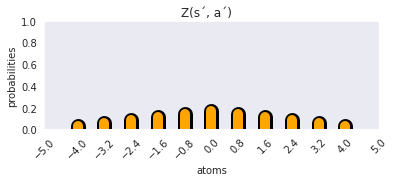

In [43]:
N = num_atoms = 11
v_min = -4
v_max = 4
delta_z = (v_max - v_min) / (N - 1)
atoms = [v_min + i * delta_z for i in range(N)] # or one can use np.linspace
# build some useful functions
def probabilities(N):
    '''Returns base probabilities given an array of size N'''
    if N % 2 == 0:
        probs = [i for i in range(1, N // 2 + 1)]
        probs.extend(probs[::-1])
        probs = probs / np.sum(probs)
    else:
        probs = [i for i in range(1, N // 2 + 1)]
        probs.extend(probs[::-1])
        probs.insert(N // 2, N // 2 + 1)
        probs = probs / np.sum((probs))
    return probs

def plot_distribution(atoms, probs=False, title=''):
    if type(probs) == bool:
        probs = [0.1 for _ in range(len(atoms))]
        linewidth = [15., 10.]
    else:
        linewidth = [15., 10.]
    sns.set_style('dark')
    plt.figure(figsize=(6, 2))
    plt.suptitle(title)
    for i, atom in enumerate(atoms):
        plt.axvline(x=atom, ymax=probs[i], linewidth=linewidth[0], color='k')
        plt.axvline(x=atom, ymax=probs[i], linewidth=linewidth[1], color='orange')
    x_ticks = list(atoms)
    x_ticks.insert(0, -5)
    x_ticks.append(5)
    plt.xticks(x_ticks, rotation=45)
    plt.xlabel('atoms')
    plt.ylabel('probabilities')
    plt.show()

# set it in action    
probs = probabilities(N)
plot_distribution(atoms, probs, title='Z(s´, a´)')

#### 3:  Distribute probabilities and project distribution

We can see how nicely the density of the target distribution is distributed onto the support of the current distribution. What happens from here is to take the cross entropy loss between the green curve and the yellow curve.

It took a while to make these curves happen, for the record.

m_l: [3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8]
m_u: [4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]
sum probs: 1.0000000000000002
sum m_probs: 0.9999999999999999


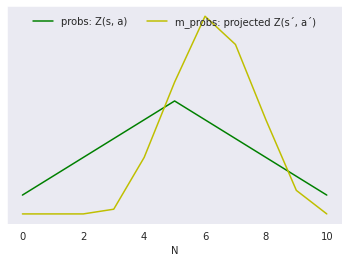

In [47]:
B = [(t_z - v_min) / delta_z for t_z in T_Z]
m_l = []
m_u = []
for b in B:
    m_l.append(math.floor(b))
    m_u.append(math.ceil(b))
print('m_l:', m_l)
print('m_u:', m_u)

m_probs = np.zeros((N))
for i, p in enumerate(probs):
    m_probs[m_l[i]] += p * (m_u[i] - B[i])
    m_probs[m_u[i]] += p * (B[i] - m_l[i])

print('sum probs:', sum(probs))
print('sum m_probs:', sum(m_probs))

plt.plot(probs, 'g', label='probs: Z(s, a)')
plt.plot(m_probs, 'y', label='m_probs: projected Z(s´, a´)')
plt.xlabel('N')
plt.yticks([])
plt.legend(loc='upper center', frameon=False, ncol=3)
plt.show()

Here we see the current distribution and the target distribution (not projected yet). 

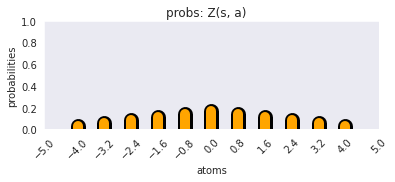

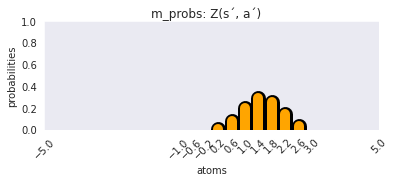

In [48]:
plot_distribution(atoms, probs, title='probs: Z(s, a)')
plot_distribution(T_Z, m_probs, title='m_probs: Z(s{`}, a{`})')

#### 4: Comparing distributions $Z(s, a)$ and $Z(s^{`}, a^{`})$ and minimizing the loss

This is done simply by passing these distributions into a cross entropy loss function.

#### 5: Sampling an action

It seems to go down like this:
1. take the expected value of each of the action value distributions, lets call that $Q(S, a)$.
2. In order to pick an action we simply apply an argmax as usual.